In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['creditcard.csv']


## Load data and visualize the data

In [2]:
credit_card = pd.read_csv('../input/creditcard.csv')

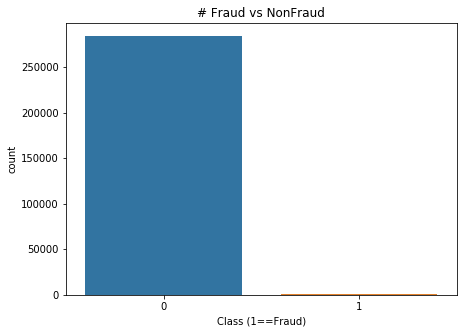

In [3]:
f, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x='Class', data=credit_card)
_ = plt.title('# Fraud vs NonFraud')
_ = plt.xlabel('Class (1==Fraud)')

As we can see we have mostly non-fraudulent transactions. Such a problem is also called inbalanced class problem.

99.8% of all transactions are non-fraudulent. The easiest classifier would always predict no fraud and would be in almost all cases correct. Such classifier would have a very high accuracy but is quite useless.

In [4]:
base_line_accuracy = 1-np.sum(credit_card.Class)/credit_card.shape[0]
base_line_accuracy

0.9982725143693799

For such an inbalanced class problem we could use over or undersampling methods to try to balance the classes (see inbalance-learn for example: https://github.com/scikit-learn-contrib/imbalanced-learn), but this out of the scope of todays post. We will come back to this in a later post.

As accuracy is not very informative in this case the AUC (Aera under the curve) a better metric to assess the model quality. The AUC in a two class classification class is equal to the probability that our classifier will detect a fraudulent transaction given one fraudulent and genuiune transaction to choice from. Guessing would have a probability of 50%.

In [5]:
X = credit_card.drop(columns='Class', axis=1)
y = credit_card.Class.values

Due to the construction of the dataset (PCA transformed features, which minimizes the correlation between factors), we dont have any highly correlated features. Multicolinearity could cause problems in a logisitc regression.

To test for multicolinearity one could look into the correlation matrix (works only for non categorical features) or run partial regressions and compare the standard errors or use pseudo-R^2 values and calculate Variance-Inflation-Factors.



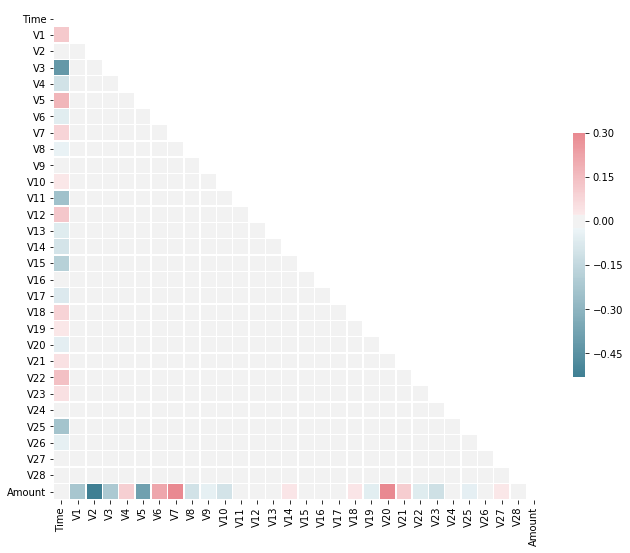

In [6]:
corr = X.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Logisitc Regression with Sklearn

Short reminder of Logistic Regression:

In Logisitic Regression the logits (logs of the odds) are assumed to be a linear function of the features

$$L=\log(\frac{P(Y=1)}{1-P(Y=1)}) = \beta_0 + \sum_{i=1}^n \beta_i X_i. $$

Solving this equatation for $p=P(Y=1)$ yields to

$$ p = \frac{\exp(L)}{1-\exp(L)}.$$

The parameters $\beta_i$ can be derived by Maximum Likelihood Estimation (MLE). The likelihood for a given $m$ observation $Y_j$ is

$$ lkl = \prod_{j=1}^m p^{Y_j}(1-p)^{1-Y_j}.$$

To find the maximum of the likelihood is equivalent to the minimize the negative logarithm of the likelihood (loglikelihood).

$$  -llkh = -\sum_{j=1}^m Y_j \log(p) + (1-Y_j) \log(1-p),$$

which is numerical more stable. The log-likelihood function has the same form as the cross-entropy error function for a discrete case.

So finding the maximum likelihood estimator is the same problem as minimizing the average cross entropy error function.

In SciKit-Learn uses by default a coordinate descent algorithm to find the minimum of L2 regularized version of the loss function (see. http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).

The main difference between L1 (Lasso) and L2 (Ridge) regulaziation is, that the L1 prefer a sparse solution (the higher the regulazation parameter the more parameter will be zero) while L2 enforce small parameter values.

## Train the model

### Training and test set

First we split our data set into a train and a validation set by using the function train_test_split. The model performace 

In [7]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Model definition

As preperation we standardize our features to have zero mean and a unit standard deviation. The convergence of gradient descent algorithm are better. We use the class `StandardScaler`. The class *StandardScaler* has the method `fit_transform()` which learn the mean $\mu_i$ and standard deviation $\sigma_i$ of each feature $i$ and return a standardized version $\frac{x_i - \mu_i}{\sigma}$. We learn the mean and sd on the training data. We can apply the same standardization on the test set with the function *transform()*.


The logistic regression is implemented in the class `LogisticRegression`, we will use for now the default parameterization. The model can be fit using the function `fit()`. After fitting the model can be used to make predicitons `predict()` or return the estimated the class probabilities `predict_proba()`.

We combine both steps into a Pipeline. The pipline performs both steps automatically. When we call the method `fit()` of the pipeline, it will invoke the method `fit_and_transform()` for all but the last step and the method `fit()` of the last step, which is equivalent to:

```python
lr.fit(scaler.fit_transform(X_train), y_train)
```

or visualized as a dataflow:

```X_train => scaler.fit_transform(.) => lr.fit(., y_train)```

If we invoke the method `predict()` of the pipeline its equvivalent to


```python
lr.predict(scaler.transform(X_train))
```





In [8]:
scaler = StandardScaler()
lr = LogisticRegression()
model1 = Pipeline([('standardize', scaler),
                    ('log_reg', lr)])

In the next step we fit our model to the training data

In [9]:
model1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

### Training score and Test score

`confusion_matrix()` returns the confusion matrix, C where $C_{0,0}$ are the true negatives (TN) and $C_{0,1}$ the false positives (FP) and vice-versa  for the positives in the 2nd row. We use the function `accurary_score()` to calculate the accuracy our models on the train and test data. We see that the accuracy is quite high (99,9%) which is expected in such an unbalanced class problem. With the method `roc_auc_score()`can we get the area under the receiver-operator-curve (AUC) for our simple model.

In [10]:
y_train_hat = model1.predict(X_train)
y_train_hat_probs = model1.predict_proba(X_train)[:,1]
train_accuracy = accuracy_score(y_train, y_train_hat)*100
train_auc_roc = roc_auc_score(y_train, y_train_hat_probs)*100
print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat))
print('Training accuracy: %.4f %%' % train_accuracy)
print('Training AUC: %.4f %%' % train_auc_roc)

Confusion matrix:
 [[213200     26]
 [   137    242]]
Training accuracy: 99.9237 %
Training AUC: 98.0664 %


![](http://)Our model is able to detect 68 fraudulent transactions out of 113 (recall of 60%) and produce 12 false alarms (<0.02%) on the test data.

In [11]:
y_test_hat = model1.predict(X_test)
y_test_hat_probs = model1.predict_proba(X_test)[:,1]
test_accuracy = accuracy_score(y_test, y_test_hat)*100
test_auc_roc = roc_auc_score(y_test, y_test_hat_probs)*100
print('Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))
print('Training accuracy: %.4f %%' % test_accuracy)
print('Training AUC: %.4f %%' % test_auc_roc)

Confusion matrix:
 [[71077    12]
 [   45    68]]
Training accuracy: 99.9199 %
Training AUC: 97.4810 %


With the function `classification_report()` we print get the precision, recall per each class.

In [12]:
print(classification_report(y_test, y_test_hat, digits=6))

             precision    recall  f1-score   support

          0   0.999367  0.999831  0.999599     71089
          1   0.850000  0.601770  0.704663       113

avg / total   0.999130  0.999199  0.999131     71202



To visualize the Receiver-Operator-Curve we use the function `roc_curve`. The method returns the true positive rate (recall) and the false positive rate (probability for a false alarm) for a bunch of different thresholds. This curve shows the trade-off between recall (detect fraud) and false alarm probability.

If we classifiy all transaction as fraud, we would have a recall of 100% but also the highest false alarm rate possible (100%). The naive way to minimize the false alarm probability is to classify all transaction as legitime. **

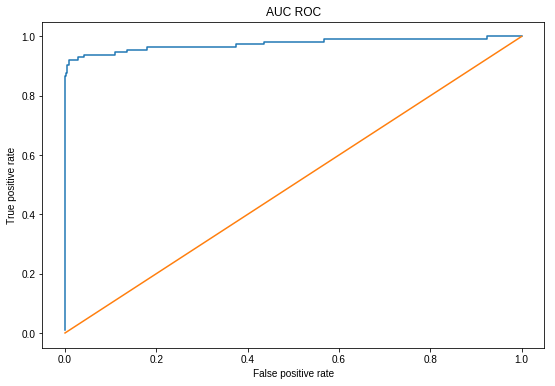

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_hat_probs, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

plt.savefig('auc_roc.png', dpi=600)

Our model classify all transaction with a fraud probability => 50% as fraud. If we choose the threshold higher, we could reach a lower false positive rate but we would also miss more fraudulent transactions. If we choose the thredhold lower we can catch more fraud but need to investigate more false positives.

Depending on the costs for each error, it make sense to select another threshold.

If we set the threshold to 90% the recall decrease from 60% to 45%. while the false positve rate is the same. We can see that our model assign some non-fraudulent a very high probability to be fraud

In [14]:
y_hat_90 = (y_test_hat_probs > 0.90 )*1
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat_90))
print(classification_report(y_test, y_hat_90, digits=6))


Confusion matrix:
 [[71077    12]
 [   62    51]]
             precision    recall  f1-score   support

          0   0.999128  0.999831  0.999480     71089
          1   0.809524  0.451327  0.579545       113

avg / total   0.998828  0.998961  0.998813     71202



If we set the threshold down to 10%, we can detect around 75% of all fraud case but almost double our false positive rate (now 25 false alarms)

In [15]:
y_hat_10 = (y_test_hat_probs > 0.10)*1
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat_10))
print(classification_report(y_test, y_hat_10, digits=4))

Confusion matrix:
 [[71064    25]
 [   25    88]]
             precision    recall  f1-score   support

          0     0.9996    0.9996    0.9996     71089
          1     0.7788    0.7788    0.7788       113

avg / total     0.9993    0.9993    0.9993     71202



Where to go from here?
-------------------

We just scratched the surface of sklearn and logistic regression. For example we could spent much more time with the 

- feature selection / engineering (which is a bit hard without any background information about the features),
- we could try techniques to counter the data inbalance and 
- we could use cross-validation to fine tune the hyperparameters (regulaziation constant C) or
- try a different regulization (Lasso/Elastic Net) or 
- optimizer (stochastic gradient desent instead of coordinate descnet)
- adjust class weights to move the decision boundary (make missed frauds more expansive in the loss function)
!- and finally we could try different classifer models in sklearn like decision trees, random forrests, knn,  naive bayes or support vector machines. 

But for now we will stop here and will implement a logisitc regression model with stochastic gradient descent in TensorFlow and then extend it to a neural net.

